<a href="https://colab.research.google.com/github/nathamon24/image-processing/blob/main/Activity%2310/Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNet
from keras.models import Model
import sys
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns


**10.1 LOAD BASE MODEL AND ADD NEW LAYERS**

In [ ]:
#Load base model
base_model = MobileNet(weights='imagenet',include_top=False)

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024,activation = 'relu')(x) #dense layer 2
x = Dense(512,activation = 'relu')(x) #dense layer 3
preds = Dense(3,activation = 'softmax')(x)

# Assign transfer base model + new layers to model
model = Model(inputs = base_model.input,outputs=preds)
# model.summary()

# Assign Trainable layers and freeze layer -> ลองเปลี่ยน ช่วง layer ในการ trainable True/False 3 ค่า เพื่อดูความแตกต่างของผลลัพธ์ที่ได้
for layer in model.layers[:20]:
  layer.trainable=False
for layer in model.layers[20:]:
  layer.trainable=True

17235968/17225924 [==============================] - 0s 0us/step


**10.2 MODEL TRAINING AND VALIDATION**

- 10.2.1 Create ImageDataGenerator (Train, Validation)



Found 97 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


<Figure size 432x288 with 0 Axes>

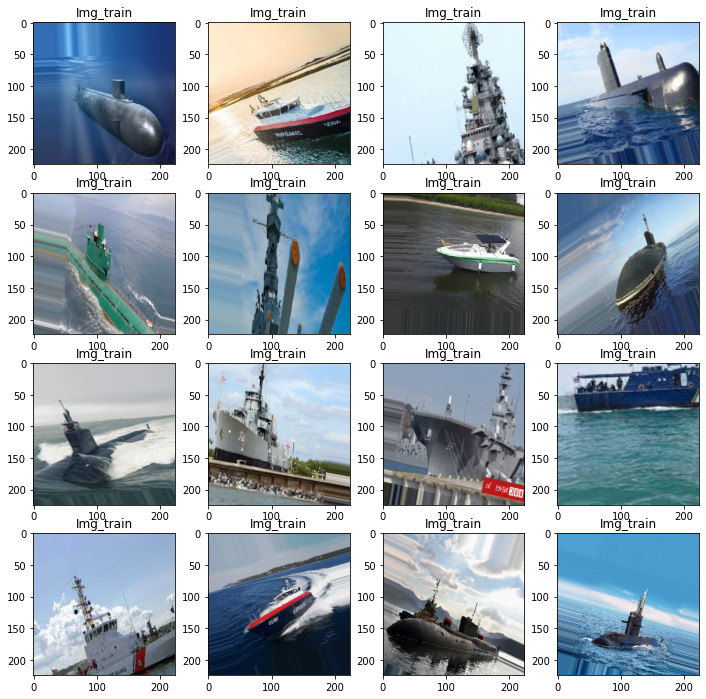

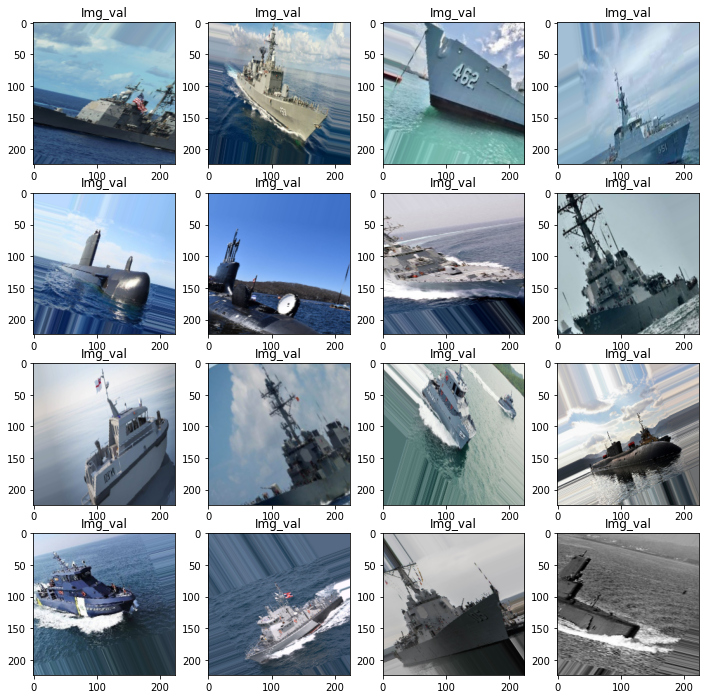

In [ ]:
#Create DataGeneartor Object
datagen = ImageDataGenerator( rescale = 1./255,
                              rotation_range = 30, 
                              zoom_range = 0.5,
                              width_shift_range = 0.2, 
                              height_shift_range = 0.2,
                              shear_range = 0.15,
                              horizontal_flip = True,
                              fill_mode = "nearest")

# Image generator parameters
seed_value = 25
img_size = (224,224)
train_path = "/content/drive/MyDrive/Work/CE/Colab/Lab10/Ship/Train"
validate_path = "/content/drive/MyDrive/Work/CE/Colab/Lab10/Ship/Validate"
test_path = "/content/drive/MyDrive/Work/CE/Colab/Lab10/Ship/Test"

# Create Train Image generator
train_generator = datagen.flow_from_directory(train_path, # this is where you specify the path to the main data folder
                                              target_size = img_size,
                                              color_mode = 'rgb',
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              seed  =  seed_value,
                                              shuffle = True)

# Create Validation Image generator
val_generator = datagen.flow_from_directory(validate_path, # this is where you specify the path to the main data folder
                                            target_size = img_size,
                                            color_mode = 'rgb',
                                            batch_size = 23,
                                            class_mode = 'categorical',
                                            seed  =  seed_value,
                                            shuffle = True)

# View Training Images and Validation Images
batch1  =  train_generator.next()
Img_train  =  (batch1[0]*255)
batch2  =  val_generator.next()
Img_val  =  (batch2[0]*255)

plt.figure()
f1, axarr1 = plt.subplots(4,4,figsize=(12,12)) 
f2, axarr2 = plt.subplots(4,4,figsize=(12,12)) 
index = 0 
for i in range(4):
  for j in range(4):
    axarr1[i][j].imshow(Img_train[index].astype(np.uint8))
    axarr2[i][j].imshow(Img_val[index].astype(np.uint8))
    axarr1[i][j].title.set_text('Img_train')
    axarr2[i][j].title.set_text('Img_val')
    index+=1

- 10.2.2 Create Optimizer, parameters

In [ ]:
# Create Optimizer
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define training Generator Parameter
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

# check step_size_Train = step_size_val -> if not adjust batch_size to make it equal
if step_size_train == step_size_val:
  print('Both steps are equal')
else :
  print(str(step_size_train))
  print(str(step_size_val))


Both steps are equal


- 10.2.3 Training, Validation, Plot accuracy, loss

Epoch 1/60
3/3 [==============================] - 69s 32s/step - loss: 2.9845 - accuracy: 0.3538 - val_loss: 2.5453 - val_accuracy: 0.2899
Epoch 2/60
3/3 [==============================] - 15s 5s/step - loss: 1.5805 - accuracy: 0.3846 - val_loss: 5.2598 - val_accuracy: 0.3188
Epoch 3/60
3/3 [==============================] - 14s 5s/step - loss: 1.2030 - accuracy: 0.4615 - val_loss: 3.1127 - val_accuracy: 0.2899
Epoch 4/60
3/3 [==============================] - 15s 7s/step - loss: 1.1820 - accuracy: 0.5385 - val_loss: 1.1786 - val_accuracy: 0.5797
Epoch 5/60
3/3 [==============================] - 14s 7s/step - loss: 0.6148 - accuracy: 0.7385 - val_loss: 3.5825 - val_accuracy: 0.3188
Epoch 6/60
3/3 [==============================] - 14s 7s/step - loss: 0.5011 - accuracy: 0.8462 - val_loss: 1.2129 - val_accuracy: 0.5652
Epoch 7/60
3/3 [==============================] - 14s 4s/step - loss: 0.3734 - accuracy: 0.8154 - val_loss: 0.6257 - val_accuracy: 0.8116
Epoch 8/60
3/3 [=================

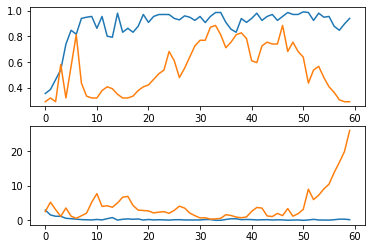

In [ ]:
EP = 60; # Number of Epoches
history = model.fit(train_generator,
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator,
                    validation_steps = step_size_val,
                    epochs = EP,
                    verbose = 1)

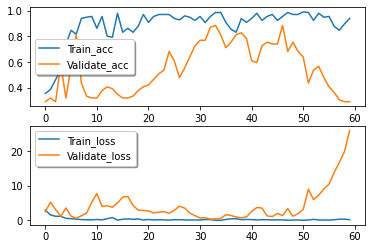

In [ ]:
# Performance Visualization
f4, ax1 = plt.subplots(2) 

# View Accuracy (Training, Validation)
ax1[0].plot(history.history["accuracy"], label="Train_acc")
ax1[0].plot(history.history["val_accuracy"], label="Validate_acc")
ax1[0].legend(shadow=True, fancybox=True)

# View Loss (Training, Validation)
ax1[1].plot(history.history['loss'], label="Train_loss")
ax1[1].plot(history.history['val_loss'], label="Validate_loss")
ax1[1].legend(shadow=True, fancybox=True)


**10.3 MODEL TESTING AND PERFORMANCE VISUALIZE**
- 10.3.1 Create ImageDataGenerator (Test) and Predict Results

Found 15 images belonging to 3 classes.


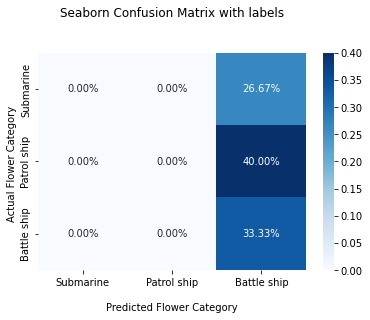

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         4
           1       1.00      0.00      0.00         6
           2       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.78      0.33      0.17        15
weighted avg       0.78      0.33      0.17        15



In [ ]:
# Initial test generator
test_datagen= ImageDataGenerator( rescale = 1./255)
test_generator = test_datagen.flow_from_directory( test_path,
                                                   class_mode = "categorical",
                                                   target_size = img_size,
                                                   color_mode ="rgb",
                                                   shuffle=False,
                                                   seed=42,
                                                   batch_size=1)

#Get class id for y_real_class
y_true = test_generator.classes

#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
# print(test_generator.next()[0])
for i in range(len(y_true)):
  pred = model.predict(test_generator.next()[0],verbose=0)
  pred_prob.append(np.array(pred[0]))

#Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)

# Calculate confusion matrix, classification report between y_true and df_class
cf_matrix = confusion_matrix(y_true, df_class)
axx = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

axx.set_title('Seaborn Confusion Matrix with labels\n\n');
axx.set_xlabel('\nPredicted Flower Category')
axx.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
axx.xaxis.set_ticklabels(['Submarine','Patrol ship', 'Battle ship'])
axx.yaxis.set_ticklabels(['Submarine','Patrol ship', 'Battle ship'])

## Display the visualization of the Confusion Matrix.
plt.show()
print(classification_report(y_true, df_class, zero_division = 1))


**QUESTION**

Q1: Number of training , validation , test images ?
- จำนวนข้อมูลในแต่ละ class มีปริมาณใกล้เคียงกันหรือไม่
- จำนวนข้อมูลทั้งหมด มีมากพอจะให้เข้าใจความแตกต่างของ class หรือไม่
Q2: Whi ch pre-train laye rs a re se t trainable?
- ปรับแล้ว มีผลต่อ accuracy มากน้อย อย่างไร

Q3: What is the maximum accuracies of train , validation , test(predict) ?

Q3: เมื่อ training ผ่านไปในแต่ละ Epoch
- Training accuracy เป็นอย่างไร เมื่อเทียบกับ Validation accuracy
- Training Loss เป็นอย่างไร เมื่อเทียบกับ Validation loss
- เพิ่มจำนวน Epoch แล้ว มีผลอย่างไรกับค่า accuracy, loss

Q4: จาก confusion matrix ดูอย่างไรว่า class ไหน ทำนายผิด และ ที่ทำนายผิด ทำนายไปเป็น class ใด